### Forward modelling using GAMMA algorithm (2D)

Interactive modelling below is a realisation of GAMMA algorithm (Gravity and Magnetic Modeling Application) for the 2D cases (Saad, 1991, 1992, 1993).<br>
The GAMMA algorithms are based on the geometric attributes of an elongated source with a polygonal cross-section perpendicular to the strike that is invariant along the strike direction (Hinze et al., 2013).<br>

Below there are the equations for the symmetric 2D case

$F_x = 2G \sigma \sum_{i=1}^N w_{1}'[C \times DLR + S \times DAT] \quad \quad F_z = g = 2G \sigma \sum_{i=1}^N w_{1}'[S \times DLR - C \times DAT]$

<img src="./gamma2d.png" width=357 height=331 />

$DX = (x_2' - X_1') \quad DZ = (z_2' - z_1') \quad DL = [(DX)^2 + (DZ)^2)]^{1/2}$

$C = cos \phi_1 = DX/DL \quad S = sin \phi_1 = DZ / DL$

$w_i' = -Sx_i' + Cx_i' \quad and \quad (w_i' = w_{i+1}')$

$DLR = ln(R_1) - ln(R_2) = ln(R_1/R_2) \quad DAT = tan^{-1}(z_1'/x_1') - tan^{-1}(z_2'/x_2')$

##### References
- Saad, A.H. 1991. Interactive Borehole Gravity Modeling (BHGM) with GAMMA. ICGC paper, Chevron InterCompany Geophys. Conf.
- Saad, A.H. 1992. GAMMA User’s Manual – Interactive Gravity And Magnetic Modeling Applications Program. Report, Chevron Expl. & Prod. Services Co.
- Saad, A.H. 1993. Interactive integrated interpretation of gravity, magnetic, and seismic data tools and examples. In Offshore Technology Conference, Paper Number OTC# 7079. Offshore Technology Conference, pp. 35–44.
- William J. Hinze et al. 1993, Gravity and Magnetic Exploration. Principles, Practices, and Applications. Cambridge University Press

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import warnings
warnings.filterwarnings('ignore')

In [2]:
class GAMMA2D(object):
    
    G = 6.67 * 10**(-11)  # gravitational constant
    
    def __init__(self, surv_points, corners, dsigma):
        self.surv_points = surv_points
        self.corners = corners
        self.dsigma = dsigma
        self.model = None
    
    def distance(self, point1, point2):
        return np.sqrt((point2[0]-point1[0])**2 + (point2[1]-point1[1])**2)
    
    def field_comp_point(self, point):
        
        Fx_corners = []
        Fz_corners = []

        point_local = point.copy()
        
        point_local[0] = point_local[0] - point[0]
        point_local[1] = point_local[1] - point[1]

        corners_local = self.corners.copy()
        corners_local[:, 0] = corners_local[:, 0] - point[0]
        corners_local[:, 1] = corners_local[:, 1] - point[1]

        for corner in range(-1, len(corners_local)):
            if corner == len(corners_local)-1:
                break
            
            DL = self.distance(corners_local[corner], corners_local[corner+1])
            DX = corners_local[corner+1][0] - corners_local[corner][0]
            DZ = corners_local[corner+1][1] - corners_local[corner][1]

            R1 = self.distance(corners_local[corner], point_local)
            R2 = self.distance(corners_local[corner+1], point_local)
            
            C = DX/DL
            S = DZ/DL
            
            w1_prime = -S * corners_local[corner][0] + C * corners_local[corner][1]
                        
            DLR = np.log(R1/R2)
                
            DAT = np.arctan2(corners_local[corner][1], corners_local[corner][0]) - \
                  np.arctan2(corners_local[corner+1][1], corners_local[corner+1][0])
            
            Fx_corners.append(w1_prime * (C*DLR + S*DAT))
            Fz_corners.append(w1_prime* (S*DLR - C*DAT))
            
        Fx = 2 * self.G * self.dsigma * np.sum(Fx_corners)
        Fz = 2 * self.G * self.dsigma * np.sum(Fz_corners)
        
        return Fx, Fz
            
    def field_comp_profile(self):
        self.model = np.array(list(map(lambda x: self.field_comp_point(x), self.surv_points)))
        return self.model

In [3]:
class RectPrism(object):
    def __init__(self, width, height, depth, dip, dsigma, cs=False):
        self.width = width
        self.height = height
        self.depth = depth
        self.dip = dip
        self.dsigma = dsigma
        self.cs = cs
        self.corners = self.corners()
  
    def corners(self):        
        
        # absolute values of x and y coordinates of corners
        x_abs = self.width/2
        y_abs = self.height/2
        
        # matrix with coordinates of corners
        c = np.array([[-x_abs, y_abs],
                      [x_abs, y_abs],
                      [x_abs, -y_abs],
                      [-x_abs, -y_abs]])
        
        # shear matrix
        R = np.array([[1, np.tan(np.radians(self.dip))],
                     [0, 1]])
        
        corners = R.dot(c.T)
        corners = corners.T
        
        if self.cs:
            corners[:, 0] = corners[:, 0] - corners[:2, 0].mean()
            corners[:, 1] = np.abs(corners[:, 1] - (self.depth + self.height/2))
        
        return corners     
            
    def plot(self, ax):
        ax.add_patch(Polygon(self.corners))

In [4]:
def plot_rectangle(rect, ax):
    rect.plot(ax)
    ax.set_xlim(-500, 500)
    ax.set_ylim(-500, 500)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(b=True, linestyle='--')
    ax.set_xlabel('East (m)')
    ax.set_ylabel('North (m)')

In [5]:
def plot_2d_body(rect, ax):
    
    rect.plot(ax)
    
    text = f'Width: {rect.width} m\nHeight: {rect.height} m\nDepth: {rect.depth} m\n$\Delta\sigma_1$: {rect.dsigma} kg/m$^3$\n'
    ax.text(x=700, y=400, s=text,
                bbox=dict(boxstyle='round', facecolor='white'))
    
    ax.set_xlim(-1000, 1000)
    ax.set_ylim(0, 500)
    
    ax.set_xticks(np.arange(-1000, 1001, 100))
    ax.xaxis.set_ticks_position('top')
    ax.grid(b=True, axis='y', linestyle='--')
    
    ax.set_ylabel('Depth (m)')
    
    ax.invert_yaxis()

In [6]:
def plot_graph(model, values, ax): 
    
    ax.plot(model.surv_points[:, 0], values)
    
    ax.set_xlim(-1000, 1000)
    ax.set_xticks(np.arange(-1000, 1001, 100))
    ax.grid(b=True, axis='y', linestyle='--')
    
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('g (mGal)')

In [7]:
def cylinder_modelling(width, height, depth, angle, dsigma):
    
    fig, axs = plt.subplot_mosaic([[0, 1, 1, 1], [0, 3, 3, 3]], figsize=(15, 6))   
    
    rect = RectPrism(width=width, height=1500, depth=0, dip=0, dsigma=dsigma, cs=False)
    plot_rectangle(rect, ax=axs[0])
    
    prism = RectPrism(width=width, height=height, depth=depth, dip=angle, dsigma=dsigma, cs=True)
    plot_2d_body(prism, ax=axs[3])
    
    x = np.linspace(-1000, 1000, 200).reshape(-1, 1)
    z = np.zeros(200).reshape(-1, 1)
    surv_points = np.concatenate([x, z], axis=1)
    
    model = GAMMA2D(surv_points=surv_points, corners=prism.corners, dsigma=prism.dsigma)
    field = model.field_comp_profile()
    plot_graph(model, field[:, 1] * 100000, axs[1])
    
    plt.tight_layout();

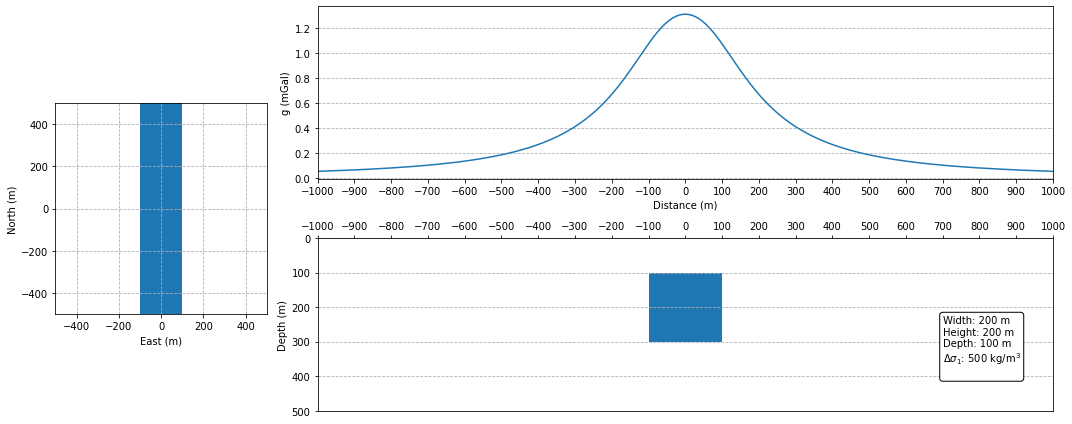

In [8]:
cylinder_modelling(200, 200, 100, 0, 500)